# Online Payments Fraud Detection

## Complete Machine Learning Pipeline

This notebook implements a complete fraud detection system using multiple machine learning algorithms.

## Step 1: Data Collection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load the dataset
data = pd.read_csv('../data/PS_20174392719_1491204439457_logs.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Step 2: Data Preprocessing

In [3]:
# Check for null values
print("Null values:")
print(data.isnull().sum())
print("\nData types:")
print(data.dtypes)

Null values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Data types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [4]:
# Remove unnecessary columns (nameOrig and nameDest are identifiers, not useful for prediction)
data_clean = data.drop(['nameOrig', 'nameDest'], axis=1)
print(f"Shape after removing unnecessary columns: {data_clean.shape}")

Shape after removing unnecessary columns: (6362620, 9)


### 2.1 Descriptive Analysis

In [5]:
# Basic statistics
print("\n=== DESCRIPTIVE STATISTICS ===")
print(data_clean.describe())
print("\n=== FRAUD DISTRIBUTION ===")
print(data_clean['isFraud'].value_counts())
print(f"\nFraud percentage: {(data_clean['isFraud'].sum() / len(data_clean)) * 100:.4f}%")


=== DESCRIPTIVE STATISTICS ===
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%  

In [6]:
# Transaction type distribution
print("\n=== TRANSACTION TYPE DISTRIBUTION ===")
print(data_clean['type'].value_counts())

# Fraud by transaction type
print("\n=== FRAUD BY TRANSACTION TYPE ===")
fraud_by_type = data_clean.groupby('type')['isFraud'].agg(['count', 'sum'])
fraud_by_type['fraud_rate'] = (fraud_by_type['sum'] / fraud_by_type['count']) * 100
print(fraud_by_type)


=== TRANSACTION TYPE DISTRIBUTION ===
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

=== FRAUD BY TRANSACTION TYPE ===
            count   sum  fraud_rate
type                               
CASH_IN   1399284     0    0.000000
CASH_OUT  2237500  4116    0.183955
DEBIT       41432     0    0.000000
PAYMENT   2151495     0    0.000000
TRANSFER   532909  4097    0.768799


### 2.2 Univariate Analysis

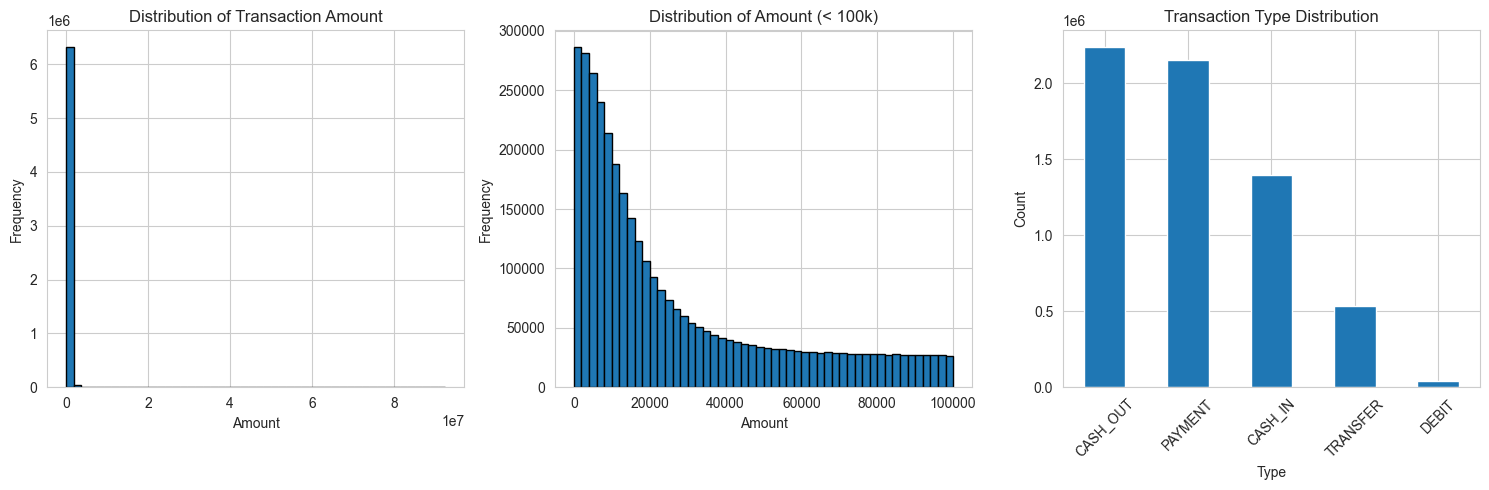

In [7]:
# Distribution of amount
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(data_clean['amount'], bins=50, edgecolor='black')
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(data_clean[data_clean['amount'] < 100000]['amount'], bins=50, edgecolor='black')
plt.title('Distribution of Amount (< 100k)')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
data_clean['type'].value_counts().plot(kind='bar')
plt.title('Transaction Type Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

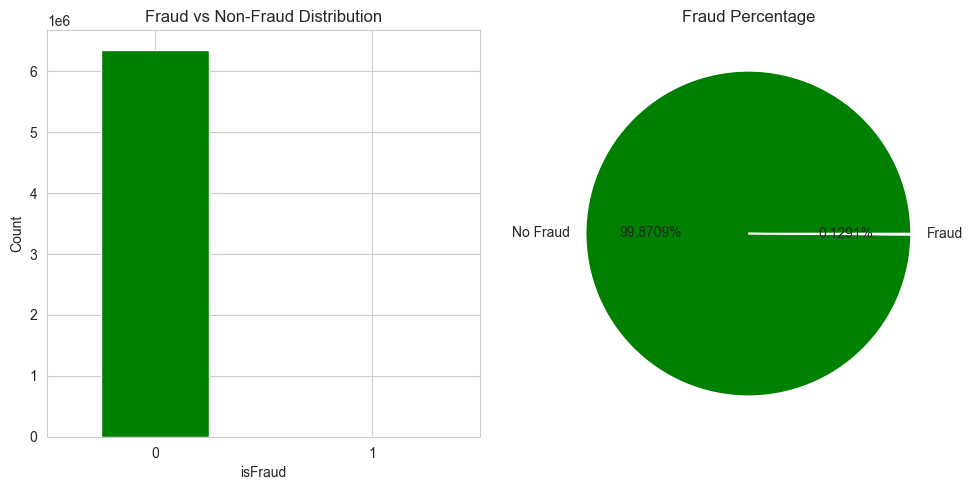

In [8]:
# Fraud vs Non-Fraud distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
data_clean['isFraud'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
fraud_counts = data_clean['isFraud'].value_counts()
plt.pie(fraud_counts, labels=['No Fraud', 'Fraud'], autopct='%1.4f%%', colors=['green', 'red'])
plt.title('Fraud Percentage')

plt.tight_layout()
plt.show()

### 2.3 Bivariate Analysis

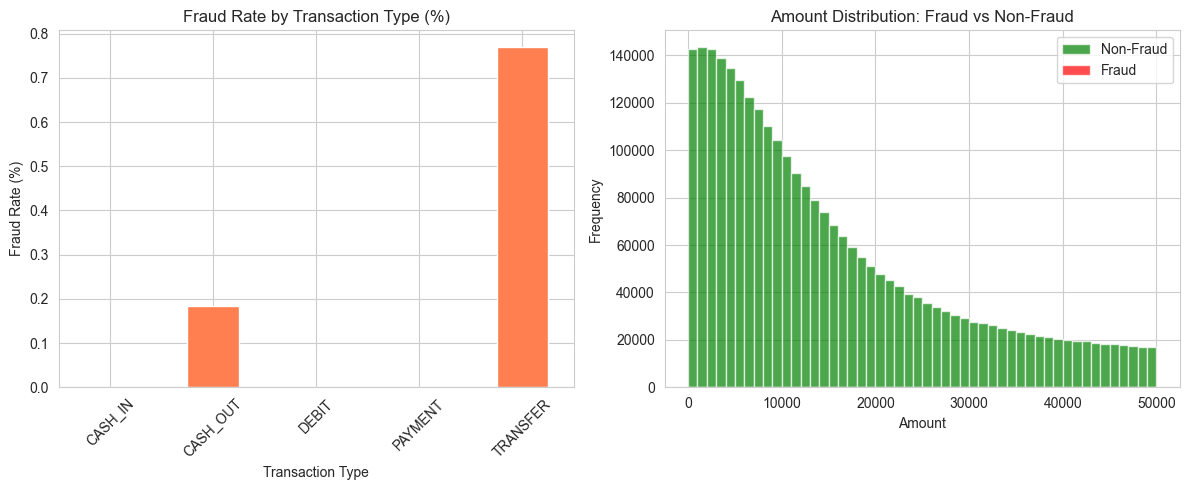

In [9]:
# Fraud by transaction type
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fraud_by_type_plot = data_clean.groupby('type')['isFraud'].mean() * 100
fraud_by_type_plot.plot(kind='bar', color='coral')
plt.title('Fraud Rate by Transaction Type (%)')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate (%)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
# Amount distribution for fraud vs non-fraud
fraud_amounts = data_clean[data_clean['isFraud'] == 1]['amount']
non_fraud_amounts = data_clean[data_clean['isFraud'] == 0]['amount']
plt.hist(non_fraud_amounts[non_fraud_amounts < 50000], bins=50, alpha=0.7, label='Non-Fraud', color='green')
plt.hist(fraud_amounts[fraud_amounts < 50000], bins=50, alpha=0.7, label='Fraud', color='red')
plt.title('Amount Distribution: Fraud vs Non-Fraud')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

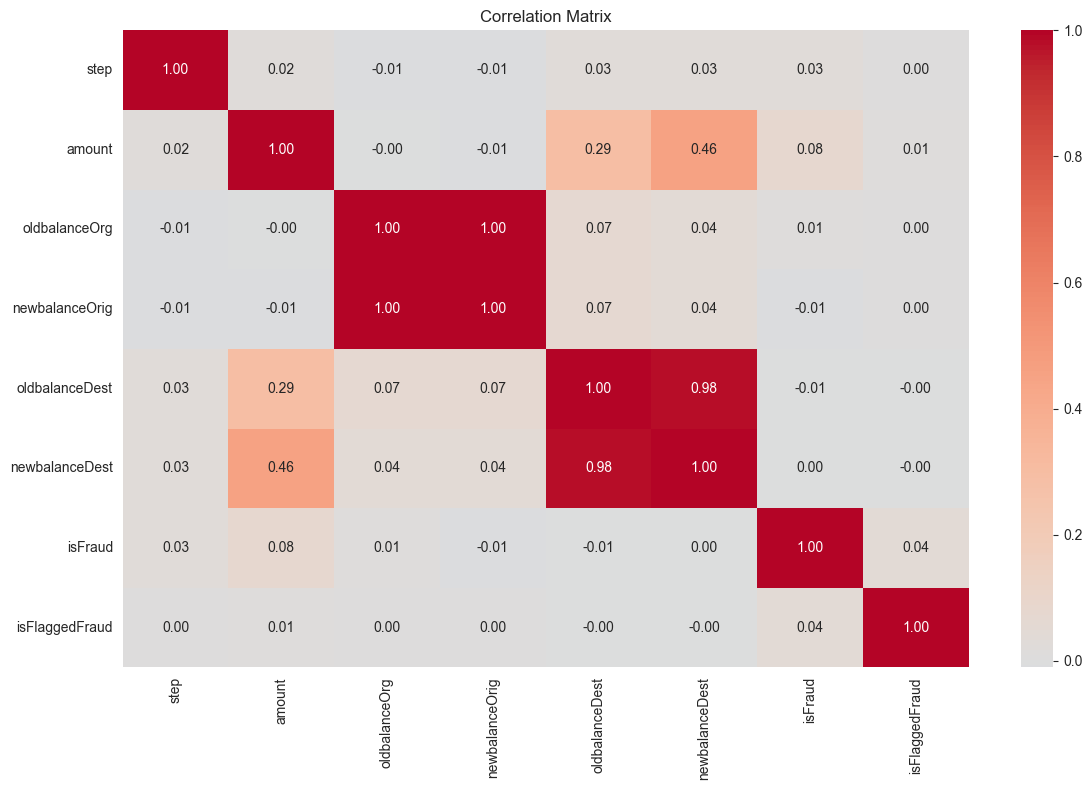


Correlation with isFraud:
isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


In [10]:
# Correlation matrix (only numeric columns)
plt.figure(figsize=(12, 8))

# Select only numeric columns
numeric_data = data_clean.select_dtypes(include=['number'])

correlation = numeric_data.corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nCorrelation with isFraud:")

if 'isFraud' in correlation.columns:
    print(correlation['isFraud'].sort_values(ascending=False))
else:
    print("Column 'isFraud' not found in numeric data.")

## Step 3: Feature Engineering

In [11]:
# Encode categorical features
data_processed = data_clean.copy()

# Map transaction type to numeric
type_mapping = {"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5}
data_processed['type'] = data_processed['type'].map(type_mapping)

print("Transaction types encoded:")
print(data_processed['type'].value_counts().sort_index())

Transaction types encoded:
type
1    2237500
2    2151495
3    1399284
4     532909
5      41432
Name: count, dtype: int64


In [12]:
# Select features for modeling
# Based on analysis, we'll use: step, type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest
features = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
target = 'isFraud'

X = data_processed[features]
y = data_processed[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {features}")

Features shape: (6362620, 7)
Target shape: (6362620,)

Features: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


## Step 4: Model Building

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set fraud rate: {(y_train.sum() / len(y_train)) * 100:.4f}%")
print(f"Test set fraud rate: {(y_test.sum() / len(y_test)) * 100:.4f}%")

Training set shape: (5090096, 7)
Test set shape: (1272524, 7)

Training set fraud rate: 0.1291%
Test set fraud rate: 0.1291%


In [ ]:

# Train multiple models and compare
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    # Use scaled data for SVM, original for others
    if name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred,
        'scaler': scaler if name == 'SVM' else None
    }
    
    print(f"{name} Accuracy: {accuracy:.6f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud']))


Training Decision Tree...


In [ ]:
# Compare model accuracies
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

accuracies = {name: results[name]['accuracy'] for name in results.keys()}
sorted_models = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

for i, (name, acc) in enumerate(sorted_models, 1):
    print(f"{i}. {name}: {acc:.6f}")

# Visualize comparison
plt.figure(figsize=(10, 6))
names = list(accuracies.keys())
scores = list(accuracies.values())
plt.barh(names, scores, color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim([min(scores) - 0.01, max(scores) + 0.01])
for i, v in enumerate(scores):
    plt.text(v, i, f' {v:.6f}', va='center')
plt.tight_layout()
plt.show()

# Select best model
best_model_name = sorted_models[0][0]
best_model = results[best_model_name]['model']
best_scaler = results[best_model_name]['scaler']

print(f"\n{'='*50}")
print(f"BEST MODEL: {best_model_name}")
print(f"Accuracy: {sorted_models[0][1]:.6f}")
print(f"{'='*50}")

## Step 5: Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for the best model
print(f"Performing hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
elif best_model_name == 'Extra Trees':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }
    base_model = ExtraTreesClassifier(random_state=42, n_jobs=-1)
elif best_model_name == 'Decision Tree':
    param_grid = {
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = DecisionTreeClassifier(random_state=42)
else:  # SVM
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.001, 0.01]
    }
    base_model = SVC(kernel='rbf', random_state=42)

# Perform grid search (using smaller subset for faster execution)
print("Note: Using subset of data for faster hyperparameter tuning...")
X_train_subset = X_train.sample(n=min(100000, len(X_train)), random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]

if best_model_name == 'SVM':
    X_train_subset_scaled = scaler.fit_transform(X_train_subset)
    grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_subset_scaled, y_train_subset)
else:
    grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_subset, y_train_subset)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.6f}")

# Train final model with best parameters
final_model = grid_search.best_estimator_

if best_model_name == 'SVM':
    final_model.fit(X_train_scaled, y_train)
    y_pred_final = final_model.predict(X_test_scaled)
else:
    final_model.fit(X_train, y_train)
    y_pred_final = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nFinal Model Accuracy: {final_accuracy:.6f}")

## Step 6: Model Evaluation

In [ ]:
# Detailed evaluation
print("\n" + "="*50)
print("FINAL MODEL EVALUATION")
print("="*50)

print(f"\nAccuracy: {final_accuracy:.6f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=['No Fraud', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print(f"\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix - Final Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Step 7: Save Model

In [ ]:
import os
import joblib

# IMPORTANT:
# Replace 'best_model' with your actual final trained model variable
model_to_save = best_model   # change if needed

# Get project root path
root_path = os.getcwd()

# Define save paths
training_path = os.path.join(root_path, "training", "payments.pkl")
flask_path = os.path.join(root_path, "flask", "payments.pkl")

# Save model
joblib.dump(model_to_save, training_path)
joblib.dump(model_to_save, flask_path)

print("Model saved successfully!")
print("Saved to:")
print(training_path)
print(flask_path)